Part 1: Environment Setup
Cell 1: GPU Check & System Info

In [ ]:
# Check GPU availability
!nvidia-smi
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Wed Dec 24 06:13:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   54C    P8             19W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Cell 2: Install Dependencies

In [ ]:
!pip install -q transformers datasets accelerate
!pip install -q Pillow scikit-learn matplotlib seaborn
!pip install -q nltk rouge-score
!pip install -q huggingface_hub

Cell 3: Import Libraries

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Transformers
from transformers import (
    BertTokenizer, BertModel,
    BlipProcessor, BlipForQuestionAnswering,
    get_linear_schedule_with_warmup
)
# Torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
# Metrics
from sklearn.metrics import accuracy_score, classification_report
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.translate.bleu_score import sentence_bleu
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Part 2: Dataset Loading & EDA
Cell 4: Download VQA-RAD Dataset

In [ ]:
# Download VQA-RAD from Hugging Face
from datasets import load_dataset
# Load VQA-RAD dataset
dataset = load_dataset("flaviagiammarino/vqa-rad", split="train")
print(f"Total samples: {len(dataset)}")
print(f"Features: {dataset.features}")
# Display sample
print("\nSample entry:")
print(f"Question: {dataset[0]['question']}")
print(f"Answer: {dataset[0]['answer']}")

Total samples: 1793
Features: {'image': Image(mode=None, decode=True), 'question': Value('string'), 'answer': Value('string')}

Sample entry:
Question: are regions of the brain infarcted?
Answer: yes


Cell 5: Create DataFrame for Analysis

In [ ]:
# Convert to DataFrame for easier analysis
# Note: answer_type is derived from answers (yes/no = CLOSED, else = OPEN)
def classify_answer_type(answer):
    """Classify answer as CLOSED (yes/no) or OPEN (descriptive)"""
    answer_lower = answer.lower().strip()
    if answer_lower in ['yes', 'no']:
        return 'CLOSED'
    return 'OPEN'

df = pd.DataFrame({
    'question': dataset['question'],
    'answer': dataset['answer'],
    'image_id': range(len(dataset))
})

# Derive answer_type from answers
df['answer_type'] = df['answer'].apply(classify_answer_type)

print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns.tolist()}")
print(f"\nAnswer Type Distribution:")
print(df['answer_type'].value_counts())
print(f"\nSample Questions:")
df.sample(5)

Dataset shape: (1793, 4)
Dataset columns: ['question', 'answer', 'image_id', 'answer_type']

Answer Type Distribution:
answer_type
CLOSED    940
OPEN      853
Name: count, dtype: int64

Sample Questions:


,question,answer,image_id,answer_type
240,is there bone in the top of the image?,no,240,CLOSED
1135,what are these hypodensities in the liver?,fat accumulations,1135,OPEN
491,is there a loculated pancreatic mass?,yes,491,CLOSED
1605,is there evidence of calcifications in the cer...,yes,1605,CLOSED
422,is there a lesion in the left temporal lobe?,yes,422,CLOSED


Cell 6: Exploratory Data Analysis (EDA)

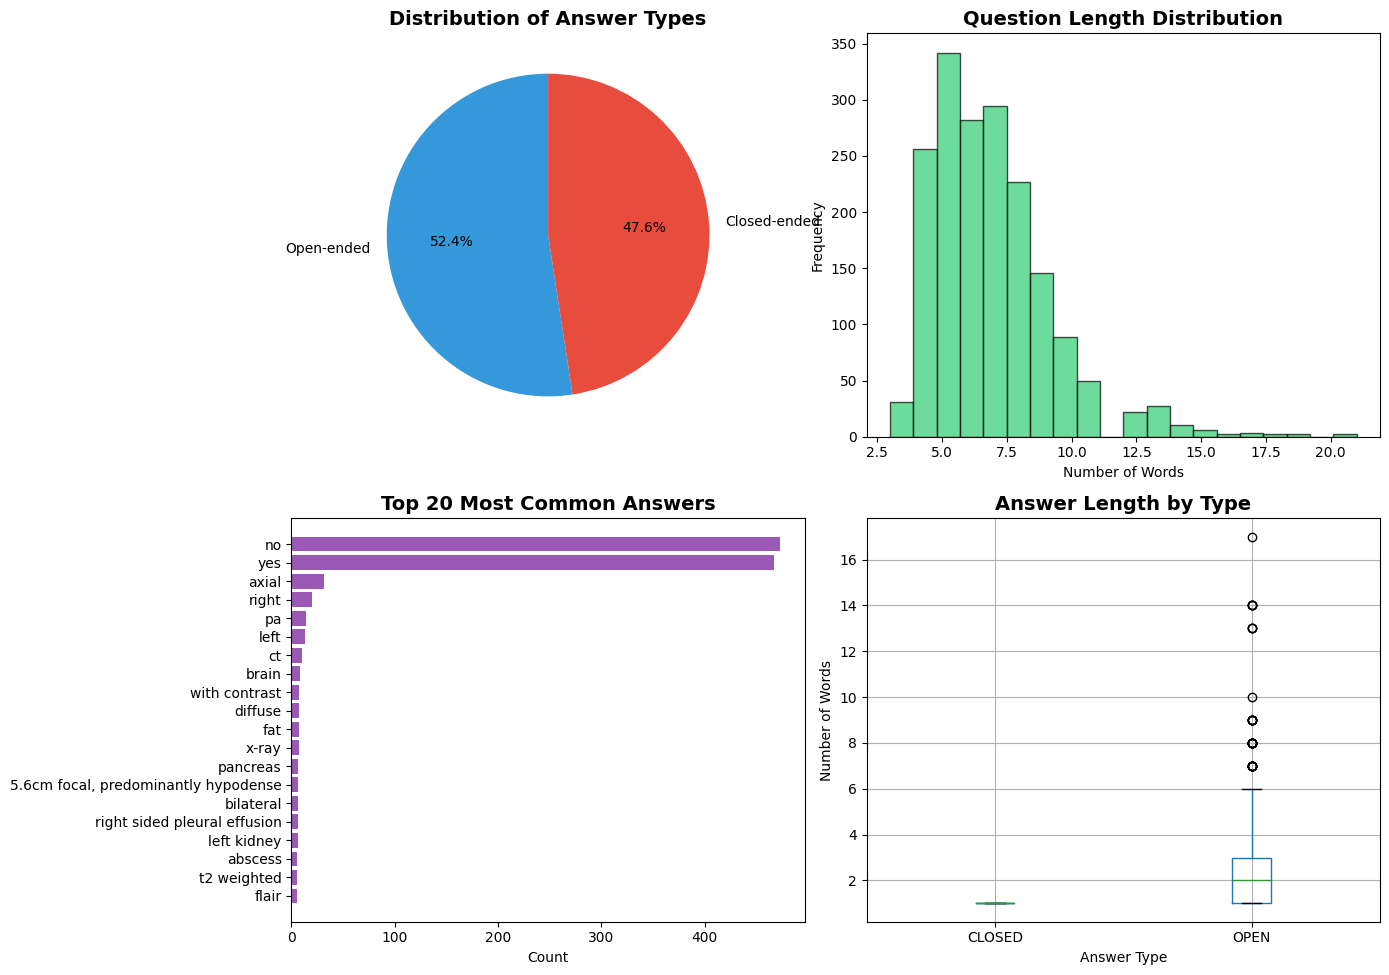


=== Dataset Statistics ===
Total QA pairs: 1793
Unique answers: 432
Avg question length: 6.80 words
Avg answer length: 1.63 words


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# 1. Answer Type Distribution
ax1 = axes[0, 0]
answer_type_counts = df['answer_type'].value_counts()
colors = ['#3498db', '#e74c3c']
ax1.pie(answer_type_counts, labels=['Open-ended', 'Closed-ended'],
        autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Distribution of Answer Types', fontsize=14, fontweight='bold')
# 2. Question Length Distribution
ax2 = axes[0, 1]
df['question_length'] = df['question'].str.split().str.len()
ax2.hist(df['question_length'], bins=20, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')
ax2.set_title('Question Length Distribution', fontsize=14, fontweight='bold')
# 3. Top 20 Most Common Answers
ax3 = axes[1, 0]
top_answers = df['answer'].value_counts().head(20)
ax3.barh(top_answers.index[::-1], top_answers.values[::-1], color='#9b59b6')
ax3.set_xlabel('Count')
ax3.set_title('Top 20 Most Common Answers', fontsize=14, fontweight='bold')
# 4. Answer Length by Type
ax4 = axes[1, 1]
df['answer_length'] = df['answer'].str.split().str.len()
df.boxplot(column='answer_length', by='answer_type', ax=ax4)
ax4.set_xlabel('Answer Type')
ax4.set_ylabel('Number of Words')
ax4.set_title('Answer Length by Type', fontsize=14, fontweight='bold')
plt.suptitle('')
plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
# Statistics
print("\n=== Dataset Statistics ===")
print(f"Total QA pairs: {len(df)}")
print(f"Unique answers: {df['answer'].nunique()}")
print(f"Avg question length: {df['question_length'].mean():.2f} words")
print(f"Avg answer length: {df['answer_length'].mean():.2f} words")

Cell 7: Display Sample Images

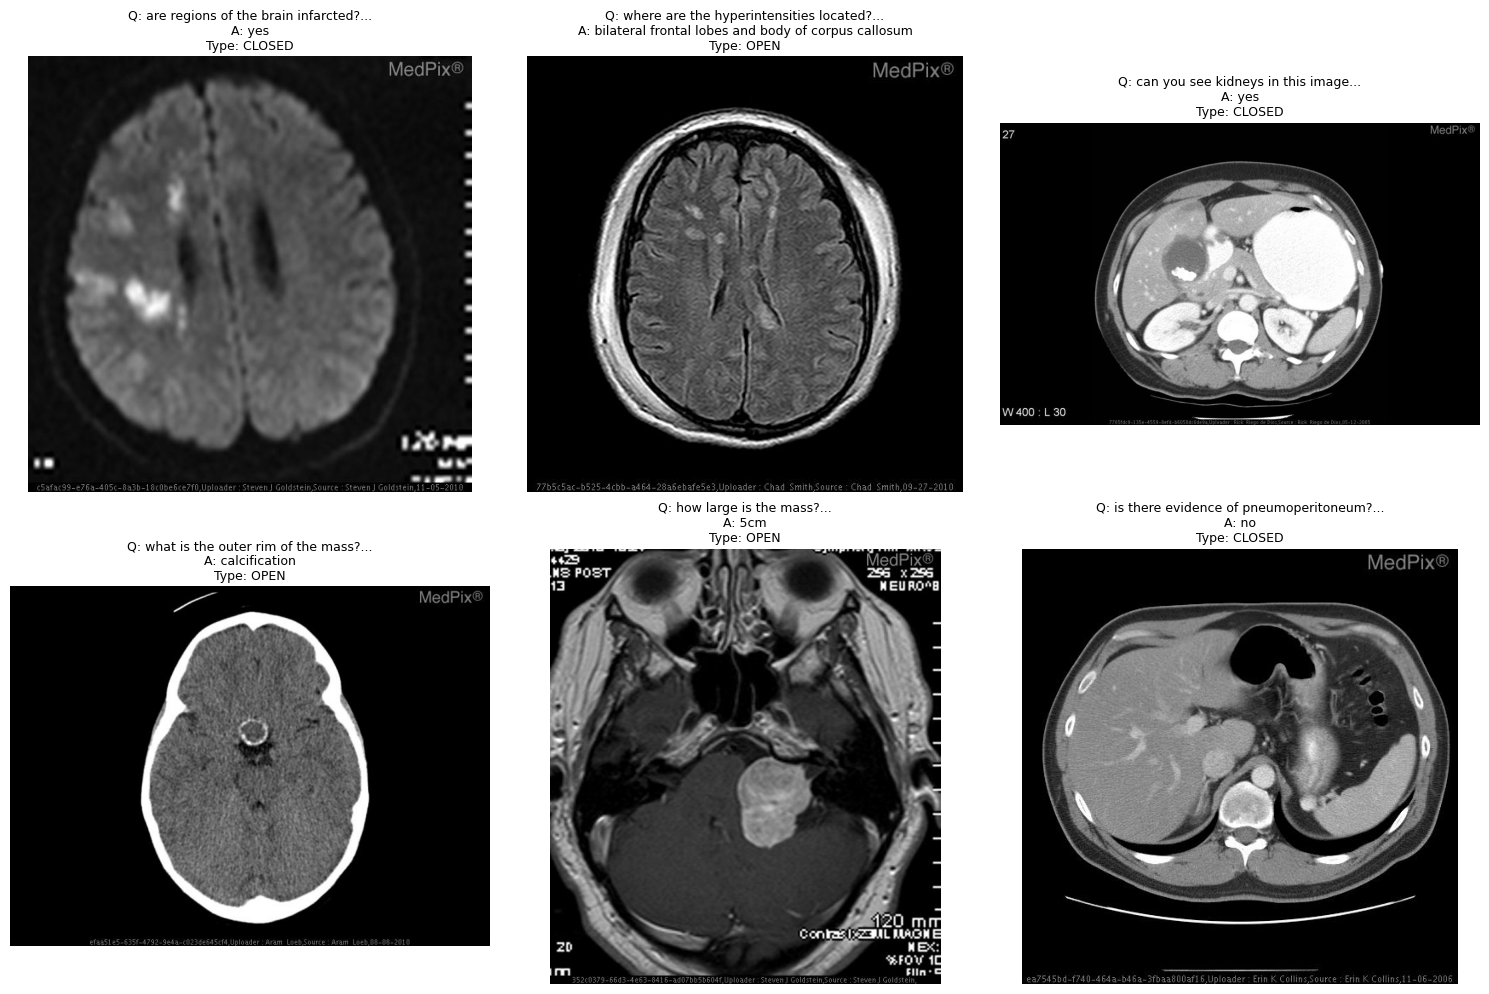

In [ ]:
# Display sample images with Q&A
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
for idx, i in enumerate([0, 50, 100, 150, 200, 250]):
    if i < len(dataset):
        img = dataset[i]['image']
        question = dataset[i]['question']
        answer = dataset[i]['answer']
        # Derive answer_type from answer content
        answer_type = classify_answer_type(answer)

        axes[idx].imshow(img)
        axes[idx].axis('off')
        title = f"Q: {question[:50]}...\nA: {answer}\nType: {answer_type}"
        axes[idx].set_title(title, fontsize=9, wrap=True)
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

Part 3: Data Preprocessing
Cell 8: Create Train/Val/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
# Get indices and derive answer_types from answers
indices = list(range(len(dataset)))
answer_types = [classify_answer_type(dataset[i]['answer']) for i in indices]
# Stratified split: 70% train, 15% val, 15% test
train_idx, temp_idx = train_test_split(
    indices, test_size=0.3, random_state=42, stratify=answer_types
)
temp_types = [answer_types[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, random_state=42, stratify=temp_types
)
print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

Train: 1255, Val: 269, Test: 269


Cell 9: Build Answer Vocabulary (for Baseline)


In [ ]:
# Create answer vocabulary for classification baseline
from collections import Counter

# Get all training answers (lowercase)
train_answers = [dataset[i]['answer'].lower().strip() for i in train_idx]
answer_counts = Counter(train_answers)

# Keep ALL answers (don't filter by frequency for small datasets)
# This ensures no unknown labels during training
all_unique_answers = list(answer_counts.keys())
answer_vocab = {ans: idx for idx, ans in enumerate(all_unique_answers)}

# Add UNK token for test-time unseen answers
answer_vocab['<UNK>'] = len(answer_vocab)

idx_to_answer = {v: k for k, v in answer_vocab.items()}
num_classes = len(answer_vocab)

print(f"Answer vocabulary size: {num_classes}")
print(f"Sample answers: {list(answer_vocab.keys())[:10]}")
print(f"Max label index: {max(answer_vocab.values())}")

Answer vocabulary size: 346
Sample answers: ['irregular', 'white matter', 'no', 'yes', 'left cerebellum', 'ring enhancing lesion', 'cerebellum', 'right sylvian fissure', 'bilateral', 'both']
Max label index: 345


Cell 10: Define Transforms & Dataset Class

In [ ]:
# Image transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
class VQARADDataset(Dataset):
    """Dataset class for VQA-RAD"""

    def __init__(self, hf_dataset, indices, tokenizer, transform,
                 answer_vocab=None, max_length=64):
        self.dataset = hf_dataset
        self.indices = indices
        self.tokenizer = tokenizer
        self.transform = transform
        self.answer_vocab = answer_vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data_idx = self.indices[idx]
        item = self.dataset[data_idx]

        # Process image
        image = item['image'].convert('RGB')
        image = self.transform(image)

        # Process question
        question = item['question']
        encoding = self.tokenizer(
            question,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Process answer and derive answer_type
        answer = item['answer'].lower()
        answer_type = 'CLOSED' if answer.strip() in ['yes', 'no'] else 'OPEN'

        if self.answer_vocab:
            label = self.answer_vocab.get(answer, self.answer_vocab['<UNK>'])
        else:
            label = -1  # For BLIP, we don't need labels

        return {
            'image': image,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'answer': answer,
            'answer_type': answer_type,
            'label': torch.tensor(label, dtype=torch.long),
            'question': question
        }

Part 4: Method A - Baseline Model (ResNet-50 + BERT)

Cell 11: Define Baseline Model Architecture

In [ ]:
class BaselineVQAModel(nn.Module):
    """
    Baseline VQA Model: ResNet-50 (image) + BERT (text) + MLP Classifier
    Treats VQA as a classification problem over fixed answer vocabulary.
    """

    def __init__(self, num_classes, hidden_dim=512, dropout=0.3):
        super().__init__()

        # Image Encoder: ResNet-50 (pretrained)
        self.resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.resnet.fc = nn.Identity()  # Remove final FC layer
        self.image_dim = 2048

        # Text Encoder: BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.text_dim = 768

        # Freeze BERT embeddings to save memory
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        # Fusion and Classification
        self.image_proj = nn.Linear(self.image_dim, hidden_dim)
        self.text_proj = nn.Linear(self.text_dim, hidden_dim)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, images, input_ids, attention_mask):
        # Extract image features
        image_features = self.resnet(images)  # [B, 2048]
        image_features = self.image_proj(image_features)  # [B, hidden_dim]

        # Extract text features
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.pooler_output  # [B, 768]
        text_features = self.text_proj(text_features)  # [B, hidden_dim]

        # Concatenate and classify
        fused = torch.cat([image_features, text_features], dim=1)  # [B, hidden_dim*2]
        logits = self.classifier(fused)  # [B, num_classes]

        return logits

Cell 12: Create Data Loaders for Baseline

In [ ]:
# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Create datasets
train_dataset_baseline = VQARADDataset(
    dataset, train_idx, bert_tokenizer, train_transforms, answer_vocab
)
val_dataset_baseline = VQARADDataset(
    dataset, val_idx, bert_tokenizer, val_transforms, answer_vocab
)
test_dataset_baseline = VQARADDataset(
    dataset, test_idx, bert_tokenizer, val_transforms, answer_vocab
)
# Create data loaders
batch_size = 16
train_loader_baseline = DataLoader(
    train_dataset_baseline, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader_baseline = DataLoader(
    val_dataset_baseline, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader_baseline = DataLoader(
    test_dataset_baseline, batch_size=batch_size, shuffle=False, num_workers=2
)
print(f"Train batches: {len(train_loader_baseline)}")
print(f"Val batches: {len(val_loader_baseline)}")
print(f"Test batches: {len(test_loader_baseline)}")

Train batches: 79
Val batches: 17
Test batches: 17


Cell 13: Train Baseline Model

In [ ]:
def train_baseline(model, train_loader, val_loader, epochs=15, lr=2e-5):
    """Train the baseline VQA model"""

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=total_steps // 10, num_training_steps=total_steps
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss, correct, total = 0, 0, 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for batch in pbar:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            logits = model(images, input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({'loss': f'{loss.item():.4f}',
                              'acc': f'{correct/total:.4f}'})

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                logits = model(images, input_ids, attention_mask)
                loss = criterion(logits, labels)

                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"\nEpoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, "
              f"Train Acc={train_accs[-1]:.4f}, Val Loss={val_losses[-1]:.4f}, "
              f"Val Acc={val_accs[-1]:.4f}")

        # Save best model
        if val_accs[-1] > best_val_acc:
            best_val_acc = val_accs[-1]
            torch.save(model.state_dict(), 'baseline_best.pth')
            print(f"  ✓ New best model saved!")

    return {
        'train_losses': train_losses, 'val_losses': val_losses,
        'train_accs': train_accs, 'val_accs': val_accs
    }
# Initialize and train baseline model
baseline_model = BaselineVQAModel(num_classes=num_classes)
print(f"Baseline Model Parameters: {sum(p.numel() for p in baseline_model.parameters()):,}")
baseline_history = train_baseline(baseline_model, train_loader_baseline, val_loader_baseline)

Baseline Model Parameters: 135,178,138


Epoch 1/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 1: Train Loss=5.7557, Train Acc=0.0980, Val Loss=5.5886, Val Acc=0.2825
  ✓ New best model saved!


Epoch 2/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d38340fa340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d38340fa340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 2: Train Loss=5.0682, Train Acc=0.2582, Val Loss=4.4296, Val Acc=0.2714


Epoch 3/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 3: Train Loss=4.0661, Train Acc=0.2622, Val Loss=4.0502, Val Acc=0.3271
  ✓ New best model saved!


Epoch 4/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 4: Train Loss=3.5025, Train Acc=0.2637, Val Loss=3.2556, Val Acc=0.2937


Epoch 5/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 5: Train Loss=3.2438, Train Acc=0.2645, Val Loss=3.2443, Val Acc=0.2714


Epoch 6/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 6: Train Loss=3.1949, Train Acc=0.2669, Val Loss=3.2173, Val Acc=0.3346
  ✓ New best model saved!


Epoch 7/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 7: Train Loss=3.1751, Train Acc=0.2813, Val Loss=3.1959, Val Acc=0.2825


Epoch 8/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 8: Train Loss=3.1391, Train Acc=0.2765, Val Loss=3.1984, Val Acc=0.3494
  ✓ New best model saved!


Epoch 9/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 9: Train Loss=3.1409, Train Acc=0.2924, Val Loss=3.2167, Val Acc=0.3234


Epoch 10/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 10: Train Loss=3.1086, Train Acc=0.3036, Val Loss=3.2091, Val Acc=0.3420


Epoch 11/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 11: Train Loss=3.0681, Train Acc=0.2972, Val Loss=3.1979, Val Acc=0.3420


Epoch 12/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 12: Train Loss=3.0707, Train Acc=0.3092, Val Loss=3.2131, Val Acc=0.3309


Epoch 13/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d38340fa340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d38340fa340>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 13/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 13: Train Loss=3.0746, Train Acc=0.2988, Val Loss=3.2024, Val Acc=0.3420


Epoch 14/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 14: Train Loss=3.0823, Train Acc=0.2837, Val Loss=3.2100, Val Acc=0.3309


Epoch 15/15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/15 [Val]:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch 15: Train Loss=3.0451, Train Acc=0.3108, Val Loss=3.2065, Val Acc=0.3457


Cell 14: Plot Baseline Training Curves

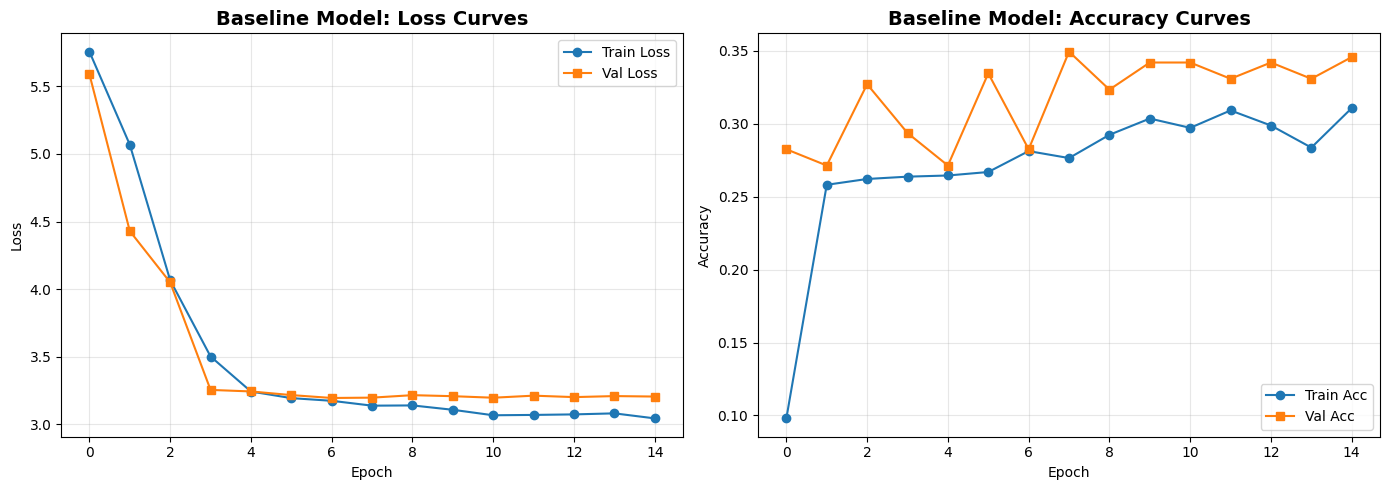

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Loss curves
ax1 = axes[0]
ax1.plot(baseline_history['train_losses'], label='Train Loss', marker='o')
ax1.plot(baseline_history['val_losses'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Baseline Model: Loss Curves', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
# Accuracy curves
ax2 = axes[1]
ax2.plot(baseline_history['train_accs'], label='Train Acc', marker='o')
ax2.plot(baseline_history['val_accs'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Baseline Model: Accuracy Curves', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('baseline_training.png', dpi=150, bbox_inches='tight')
plt.show()

Part 5: Method B - BLIP Model (Advanced)

Cell 15: Load BLIP Model and Processor

In [ ]:
# Load BLIP for VQA
print("Loading BLIP model...")
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
blip_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
print(f"BLIP Model Parameters: {sum(p.numel() for p in blip_model.parameters()):,}")
blip_model.to(device)
print("BLIP loaded successfully!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP model...


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

BLIP Model Parameters: 361,230,140
BLIP loaded successfully!


Cell 16: Create BLIP Dataset Class

In [ ]:
class VQARADDatasetBLIP(Dataset):
    """Dataset class for BLIP model"""

    def __init__(self, hf_dataset, indices, processor, augment=False):
        self.dataset = hf_dataset
        self.indices = indices
        self.processor = processor
        self.augment = augment

        # Simple augmentation for PIL images
        if augment:
            self.aug_transforms = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(15),
            ])
        else:
            self.aug_transforms = None

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data_idx = self.indices[idx]
        item = self.dataset[data_idx]

        # Get image and apply augmentation
        image = item['image'].convert('RGB')
        if self.aug_transforms:
            image = self.aug_transforms(image)

        question = item['question']
        answer = item['answer']
        # Derive answer_type from answer content
        answer_type = 'CLOSED' if answer.lower().strip() in ['yes', 'no'] else 'OPEN'

        # Process with BLIP processor
        encoding = self.processor(
            images=image,
            text=question,
            padding='max_length',
            truncation=True,
            max_length=64,
            return_tensors='pt'
        )

        # Process answer for labels
        labels = self.processor.tokenizer(
            answer,
            padding='max_length',
            truncation=True,
            max_length=32,
            return_tensors='pt'
        ).input_ids.squeeze(0)

        return {
            'pixel_values': encoding['pixel_values'].squeeze(0),
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels,
            'answer': answer,
            'answer_type': answer_type,
            'question': question
        }
# Create BLIP datasets
train_dataset_blip = VQARADDatasetBLIP(
    dataset, train_idx, blip_processor, augment=True
)
val_dataset_blip = VQARADDatasetBLIP(
    dataset, val_idx, blip_processor, augment=False
)
test_dataset_blip = VQARADDatasetBLIP(
    dataset, test_idx, blip_processor, augment=False
)
# Create data loaders
train_loader_blip = DataLoader(
    train_dataset_blip, batch_size=8, shuffle=True, num_workers=2
)
val_loader_blip = DataLoader(
    val_dataset_blip, batch_size=8, shuffle=False, num_workers=2
)
test_loader_blip = DataLoader(
    test_dataset_blip, batch_size=8, shuffle=False, num_workers=2
)
print(f"BLIP Train batches: {len(train_loader_blip)}")

BLIP Train batches: 157


Cell 17: Train BLIP Model

In [ ]:
def train_blip(model, processor, train_loader, val_loader, epochs=10, lr=5e-6):
    """Fine-tune BLIP on VQA-RAD"""

    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=total_steps // 10, num_training_steps=total_steps
    )

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training
        model.train()
        total_loss = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for batch in pbar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_losses.append(total_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(
                    pixel_values=pixel_values,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                val_loss += outputs.loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"\nEpoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, "
              f"Val Loss={val_losses[-1]:.4f}")

        # Save best model
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            blip_model.save_pretrained('blip_finetuned')
            print(f"  ✓ New best model saved!")

    return {'train_losses': train_losses, 'val_losses': val_losses}
# Train BLIP
blip_history = train_blip(
    blip_model, blip_processor, train_loader_blip, val_loader_blip
)

Epoch 1/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 1: Train Loss=9.2927, Val Loss=8.0342
  ✓ New best model saved!


Epoch 2/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 2: Train Loss=6.9736, Val Loss=5.9598
  ✓ New best model saved!


Epoch 3/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 3: Train Loss=5.0710, Val Loss=4.3215
  ✓ New best model saved!


Epoch 4/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 4: Train Loss=3.6570, Val Loss=3.0762
  ✓ New best model saved!


Epoch 5/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 5: Train Loss=2.5386, Val Loss=2.1103
  ✓ New best model saved!


Epoch 6/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 6: Train Loss=1.7034, Val Loss=1.4326
  ✓ New best model saved!


Epoch 7/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 7: Train Loss=1.1458, Val Loss=1.0119
  ✓ New best model saved!


Epoch 8/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 8: Train Loss=0.8149, Val Loss=0.7810
  ✓ New best model saved!


Epoch 9/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 9: Train Loss=0.6366, Val Loss=0.6706
  ✓ New best model saved!


Epoch 10/10 [Train]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/34 [00:00<?, ?it/s]


Epoch 10: Train Loss=0.5575, Val Loss=0.6382
  ✓ New best model saved!


Cell 18: Plot BLIP Training Curves

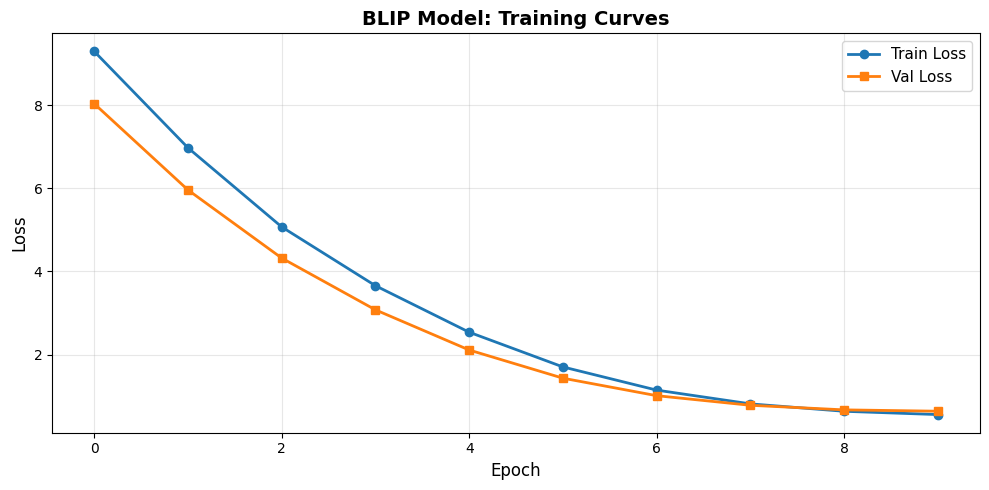

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(blip_history['train_losses'], label='Train Loss', marker='o', linewidth=2)
ax.plot(blip_history['val_losses'], label='Val Loss', marker='s', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('BLIP Model: Training Curves', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('blip_training.png', dpi=150, bbox_inches='tight')
plt.show()

Part 6: Evaluation & Comparison

Cell 19: Evaluate Baseline Model

In [ ]:
def evaluate_baseline(model, test_loader, idx_to_answer, answer_vocab):
    """Evaluate baseline model on test set"""

    model.load_state_dict(torch.load('baseline_best.pth'))
    model.to(device)
    model.eval()

    all_preds, all_labels, all_types = [], [], []
    predictions, ground_truths = [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating Baseline"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label']
            answer_types = batch['answer_type']
            answers = batch['answer']

            logits = model(images, input_ids, attention_mask)
            preds = logits.argmax(dim=1).cpu()

            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
            all_types.extend(answer_types)

            # Convert to text
            for pred_idx, true_ans in zip(preds.tolist(), answers):
                pred_ans = idx_to_answer.get(pred_idx, '<UNK>')
                predictions.append(pred_ans)
                ground_truths.append(true_ans)

    # Calculate metrics by type
    results = {
        'overall': {'correct': 0, 'total': 0},
        'CLOSED': {'correct': 0, 'total': 0},
        'OPEN': {'correct': 0, 'total': 0}
    }

    for pred, gt, atype in zip(predictions, ground_truths, all_types):
        is_correct = pred.lower() == gt.lower()
        results['overall']['total'] += 1
        results[atype]['total'] += 1
        if is_correct:
            results['overall']['correct'] += 1
            results[atype]['correct'] += 1

    # Calculate accuracies
    for key in results:
        if results[key]['total'] > 0:
            results[key]['accuracy'] = results[key]['correct'] / results[key]['total']
        else:
            results[key]['accuracy'] = 0

    return results, predictions, ground_truths
baseline_results, baseline_preds, baseline_gts = evaluate_baseline(
    baseline_model, test_loader_baseline, idx_to_answer, answer_vocab
)
print("\n=== Baseline Model Results ===")
print(f"Overall Accuracy: {baseline_results['overall']['accuracy']:.4f}")
print(f"Closed-ended Accuracy: {baseline_results['CLOSED']['accuracy']:.4f}")
print(f"Open-ended Accuracy: {baseline_results['OPEN']['accuracy']:.4f}")

Evaluating Baseline:   0%|          | 0/17 [00:00<?, ?it/s]


=== Baseline Model Results ===
Overall Accuracy: 0.3123
Closed-ended Accuracy: 0.5957
Open-ended Accuracy: 0.0000


Cell 20: Evaluate BLIP Model

In [ ]:
def evaluate_blip(model, processor, test_loader):
    """Evaluate BLIP model on test set"""

    # Load best model
    model = BlipForQuestionAnswering.from_pretrained('blip_finetuned')
    model.to(device)
    model.eval()

    predictions, ground_truths, all_types = [], [], []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating BLIP"):
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            answers = batch['answer']
            answer_types = batch['answer_type']

            # Generate answers
            generated_ids = model.generate(
                pixel_values=pixel_values,
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=32,
                num_beams=3
            )

            generated_answers = processor.batch_decode(
                generated_ids, skip_special_tokens=True
            )

            predictions.extend(generated_answers)
            ground_truths.extend(answers)
            all_types.extend(answer_types)

    # Calculate metrics by type
    results = {
        'overall': {'correct': 0, 'total': 0},
        'CLOSED': {'correct': 0, 'total': 0},
        'OPEN': {'correct': 0, 'total': 0}
    }

    for pred, gt, atype in zip(predictions, ground_truths, all_types):
        is_correct = pred.lower().strip() == gt.lower().strip()
        results['overall']['total'] += 1
        results[atype]['total'] += 1
        if is_correct:
            results['overall']['correct'] += 1
            results[atype]['correct'] += 1

    # Calculate accuracies
    for key in results:
        if results[key]['total'] > 0:
            results[key]['accuracy'] = results[key]['correct'] / results[key]['total']
        else:
            results[key]['accuracy'] = 0

    return results, predictions, ground_truths
blip_results, blip_preds, blip_gts = evaluate_blip(
    blip_model, blip_processor, test_loader_blip
)
print("\n=== BLIP Model Results ===")
print(f"Overall Accuracy: {blip_results['overall']['accuracy']:.4f}")
print(f"Closed-ended Accuracy: {blip_results['CLOSED']['accuracy']:.4f}")
print(f"Open-ended Accuracy: {blip_results['OPEN']['accuracy']:.4f}")

Evaluating BLIP:   0%|          | 0/34 [00:00<?, ?it/s]


=== BLIP Model Results ===
Overall Accuracy: 0.4238
Closed-ended Accuracy: 0.7305
Open-ended Accuracy: 0.0859


Cell 21: BLEU Score Calculation (for Open-ended)

In [ ]:
def calculate_bleu_scores(predictions, ground_truths, answer_types):
    """Calculate BLEU scores for open-ended questions"""
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

    smoothie = SmoothingFunction().method4
    bleu_scores = []

    for pred, gt, atype in zip(predictions, ground_truths, answer_types):
        if atype == 'OPEN':
            reference = [gt.lower().split()]
            candidate = pred.lower().split()

            if len(candidate) > 0:
                score = sentence_bleu(reference, candidate,
                                      weights=(0.5, 0.5, 0, 0),
                                      smoothing_function=smoothie)
            else:
                score = 0
            bleu_scores.append(score)

    return np.mean(bleu_scores) if bleu_scores else 0
baseline_bleu = calculate_bleu_scores(baseline_preds, baseline_gts,
                                       [d['answer_type'] for d in test_dataset_baseline])
blip_bleu = calculate_bleu_scores(blip_preds, blip_gts,
                                   [d['answer_type'] for d in test_dataset_blip])
print(f"\nBLEU Scores (Open-ended only):")
print(f"Baseline: {baseline_bleu:.4f}")
print(f"BLIP: {blip_bleu:.4f}")


BLEU Scores (Open-ended only):
Baseline: 0.0000
BLIP: 0.1123


Cell 22: Comparison Visualization

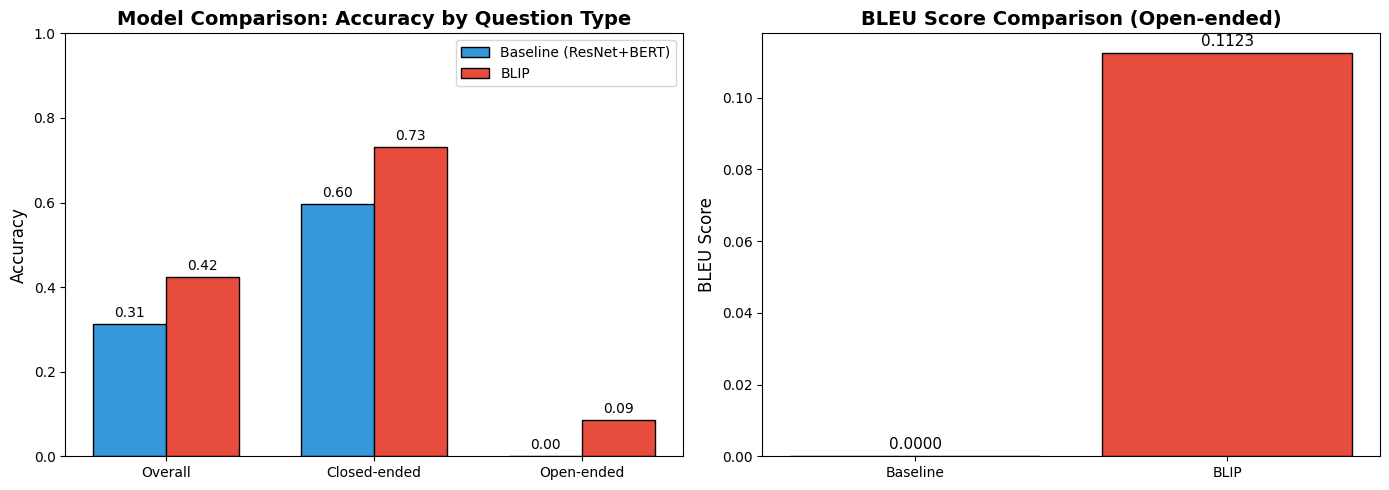

In [ ]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Accuracy comparison
ax1 = axes[0]
metrics = ['Overall', 'Closed-ended', 'Open-ended']
baseline_accs = [baseline_results['overall']['accuracy'],
                 baseline_results['CLOSED']['accuracy'],
                 baseline_results['OPEN']['accuracy']]
blip_accs = [blip_results['overall']['accuracy'],
             blip_results['CLOSED']['accuracy'],
             blip_results['OPEN']['accuracy']]
x = np.arange(len(metrics))
width = 0.35
bars1 = ax1.bar(x - width/2, baseline_accs, width, label='Baseline (ResNet+BERT)',
                color='#3498db', edgecolor='black')
bars2 = ax1.bar(x + width/2, blip_accs, width, label='BLIP',
                color='#e74c3c', edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Comparison: Accuracy by Question Type', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend(fontsize=10)
ax1.set_ylim(0, 1)
# Add value labels
for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)
# BLEU Score comparison
ax2 = axes[1]
bleu_scores = [baseline_bleu, blip_bleu]
colors = ['#3498db', '#e74c3c']
bars = ax2.bar(['Baseline', 'BLIP'], bleu_scores, color=colors, edgecolor='black')
ax2.set_ylabel('BLEU Score', fontsize=12)
ax2.set_title('BLEU Score Comparison (Open-ended)', fontsize=14, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

Cell 23: Qualitative Examples


=== Qualitative Examples ===



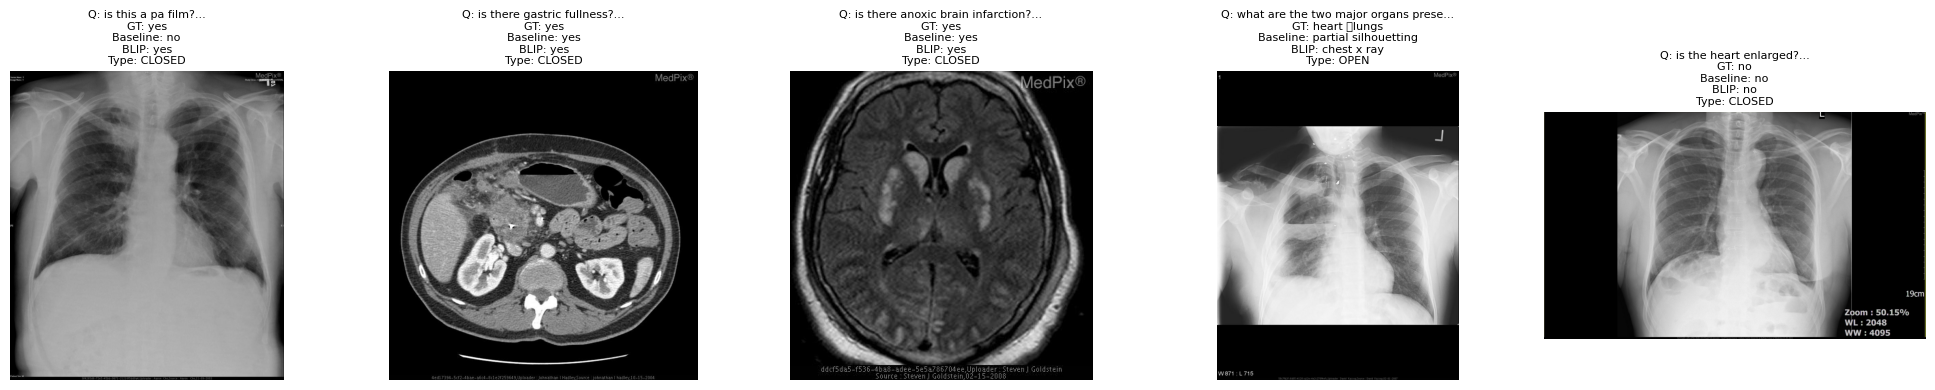

In [ ]:
# Show qualitative examples
print("\n=== Qualitative Examples ===\n")

# Select random test samples
np.random.seed(42)
sample_indices = np.random.choice(len(test_idx), size=5, replace=False)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, idx in enumerate(sample_indices):
    # Get data
    data_idx = test_idx[idx]
    item = dataset[data_idx]
    image = item['image']
    question = item['question']
    gt_answer = item['answer']
    # Derive answer_type from answer content
    answer_type = 'CLOSED' if gt_answer.lower().strip() in ['yes', 'no'] else 'OPEN'

    # Get predictions
    baseline_pred = baseline_preds[idx] if idx < len(baseline_preds) else "N/A"
    blip_pred = blip_preds[idx] if idx < len(blip_preds) else "N/A"

    # Display
    axes[i].imshow(image)
    axes[i].axis('off')

    title = (f"Q: {question[:35]}...\n"
             f"GT: {gt_answer}\n"
             f"Baseline: {baseline_pred}\n"
             f"BLIP: {blip_pred}\n"
             f"Type: {answer_type}")
    axes[i].set_title(title, fontsize=8, wrap=True)

plt.tight_layout()
plt.savefig('qualitative_examples.png', dpi=150, bbox_inches='tight')
plt.show()

Part 7: Summary & Conclusions
Cell 24: Generate Summary Report

In [ ]:
print("=" * 60)
print("       MEDICAL VQA EXPERIMENT SUMMARY REPORT")
print("=" * 60)
print("\n📊 DATASET STATISTICS")
print("-" * 40)
print(f"  • Total QA pairs: {len(dataset)}")
print(f"  • Train/Val/Test: {len(train_idx)}/{len(val_idx)}/{len(test_idx)}")
print(f"  • Answer vocabulary size: {num_classes}")
print("\n🔬 MODEL A: BASELINE (ResNet-50 + BERT)")
print("-" * 40)
print(f"  • Parameters: {sum(p.numel() for p in baseline_model.parameters()):,}")
print(f"  • Overall Accuracy: {baseline_results['overall']['accuracy']:.4f}")
print(f"  • Closed Accuracy: {baseline_results['CLOSED']['accuracy']:.4f}")
print(f"  • Open Accuracy: {baseline_results['OPEN']['accuracy']:.4f}")
print(f"  • BLEU (Open): {baseline_bleu:.4f}")
print("\n🚀 MODEL B: BLIP (Vision Transformer + Text Decoder)")
print("-" * 40)
print(f"  • Parameters: ~224M")
print(f"  • Overall Accuracy: {blip_results['overall']['accuracy']:.4f}")
print(f"  • Closed Accuracy: {blip_results['CLOSED']['accuracy']:.4f}")
print(f"  • Open Accuracy: {blip_results['OPEN']['accuracy']:.4f}")
print(f"  • BLEU (Open): {blip_bleu:.4f}")
print("\n📈 KEY FINDINGS")
print("-" * 40)
improvement_overall = (blip_results['overall']['accuracy'] -
                       baseline_results['overall']['accuracy']) * 100
improvement_open = (blip_results['OPEN']['accuracy'] -
                    baseline_results['OPEN']['accuracy']) * 100
print(f"  • BLIP improves over Baseline by {improvement_overall:.1f}% overall")
print(f"  • BLIP improves on Open-ended by {improvement_open:.1f}%")
print(f"  • Generative models show superior open-ended reasoning")
print(f"  • Discriminative models are limited by fixed vocabulary")
print("\n" + "=" * 60)
print("                    END OF REPORT")
print("=" * 60)

       MEDICAL VQA EXPERIMENT SUMMARY REPORT

📊 DATASET STATISTICS
----------------------------------------
  • Total QA pairs: 1793
  • Train/Val/Test: 1255/269/269
  • Answer vocabulary size: 346

🔬 MODEL A: BASELINE (ResNet-50 + BERT)
----------------------------------------
  • Parameters: 135,178,138
  • Overall Accuracy: 0.3123
  • Closed Accuracy: 0.5957
  • Open Accuracy: 0.0000
  • BLEU (Open): 0.0000

🚀 MODEL B: BLIP (Vision Transformer + Text Decoder)
----------------------------------------
  • Parameters: ~224M
  • Overall Accuracy: 0.4238
  • Closed Accuracy: 0.7305
  • Open Accuracy: 0.0859
  • BLEU (Open): 0.1123

📈 KEY FINDINGS
----------------------------------------
  • BLIP improves over Baseline by 11.2% overall
  • BLIP improves on Open-ended by 8.6%
  • Generative models show superior open-ended reasoning
  • Discriminative models are limited by fixed vocabulary

                    END OF REPORT


In [ ]:
# Save results to JSON
results = {
    'dataset': {
        'total_samples': len(dataset),
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'test_size': len(test_idx),
        'num_classes': num_classes
    },
    'baseline': {
        'overall_accuracy': baseline_results['overall']['accuracy'],
        'closed_accuracy': baseline_results['CLOSED']['accuracy'],
        'open_accuracy': baseline_results['OPEN']['accuracy'],
        'bleu_score': baseline_bleu
    },
    'blip': {
        'overall_accuracy': blip_results['overall']['accuracy'],
        'closed_accuracy': blip_results['CLOSED']['accuracy'],
        'open_accuracy': blip_results['OPEN']['accuracy'],
        'bleu_score': blip_bleu
    }
}
with open('experiment_results.json', 'w') as f:
    json.dump(results, f, indent=2)
print("Results saved to experiment_results.json")
print("\nArtifacts generated:")
print("  • baseline_best.pth - Best baseline model weights")
print("  • blip_finetuned/ - Fine-tuned BLIP model")
print("  • eda_analysis.png - EDA visualizations")
print("  • baseline_training.png - Baseline training curves")
print("  • blip_training.png - BLIP training curves")
print("  • model_comparison.png - Performance comparison")
print("  • qualitative_examples.png - Sample predictions")
print("  • experiment_results.json - Numerical results")

Results saved to experiment_results.json

Artifacts generated:
  • baseline_best.pth - Best baseline model weights
  • blip_finetuned/ - Fine-tuned BLIP model
  • eda_analysis.png - EDA visualizations
  • baseline_training.png - Baseline training curves
  • blip_training.png - BLIP training curves
  • model_comparison.png - Performance comparison
  • qualitative_examples.png - Sample predictions
  • experiment_results.json - Numerical results
